# Sistema de Recomendación basado en Clientes Similares

## Introducción

Este sistema de recomendación se basa en la similitud entre clientes, con el objetivo de sugerir productos que han sido comprados por otros usuarios con un comportamiento de compra similar. Se emplea un enfoque de filtrado colaborativo basado en clientes (*Customer-based Collaborative Filtering*).

El sistema parte del mismo dataset utilizado previamente para el análisis de **segmentación de clientes**, el cual fue normalizado y enriquecido con variables relevantes de comportamiento y características demográficas. Aprovechar este dataset permite reutilizar una base coherente y ya preparada para análisis de similitud entre perfiles.

## Dataset utilizado

El dataset `customer_segmentation_normalized` contiene variables derivadas del historial de navegación y compra, procesadas mediante técnicas de escalado, log-transformación y codificación. Incluye:

- **Métricas de compra**: `total_amount_sum_log`, `avg_order_value_log`, `promo_usage_rate_log`, `avg_promo_discount_log`
- **Comportamiento temporal**: `recency_days_log`, `first_purchase_days`, `average_time_transaction_winsorized`
- **Datos sociodemográficos y técnicos**: `age_winsorized`, `device_type_mode_encoded`, `traffic_source_mode_encoded`, `home_location_freq_encoded`
- **Métodos de pago** (one-hot): `most_used_payment_credit_card`, `most_used_payment_gopay`, `most_used_payment_ovo`, etc.
- **Género codificado**: `customer_gender_encoded`

Opcionalmente, se puede añadir una columna `cluster_id` con el resultado del modelo de segmentación de clientes, para incorporar la lógica de segmentos al sistema de recomendación.

## Enfoque del modelo

Se emplearán algoritmos de similitud como **K-Nearest Neighbors (KNN)** o **Annoy**, con las siguientes estrategias:

1. **Cálculo de similitud entre clientes** utilizando las variables normalizadas.
2. **Identificación de los vecinos más cercanos** para cada cliente.
3. **Recomendación de productos** basada en compras de los clientes más similares.
4. **Uso del `cluster_id` (opcional)**:
   - Filtrar vecinos dentro del mismo clúster (filtrado duro).
   - Priorizar vecinos del mismo clúster (filtrado suave).
   - Recomendaciones populares por clúster (para usuarios nuevos o *cold start*).

## Objetivo

El objetivo final es ofrecer recomendaciones personalizadas de productos que aumenten la relevancia para cada cliente, mejoren la experiencia de usuario, potencien la conversión y fortalezcan la fidelización, mediante la explotación de similitudes en los hábitos de compra y navegación.


In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine,text
from sklearn.neighbors import NearestNeighbors
import folium
from IPython.display import display, HTML
import random
from annoy import AnnoyIndex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuración de conexión
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexión a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Creación de la Tabla `customer_similarity_input`

## Objetivo

Con el fin de desarrollar un sistema de recomendación basado en clientes similares, es necesario disponer de un dataset consolidado que combine:

- Las variables normalizadas y transformadas utilizadas en el análisis de segmentación de clientes (`customer_segmentation_normalized`).
- El resultado del clustering aplicado previamente a los clientes, que identifica a qué segmento (`cluster`) pertenece cada uno (`customer_segmentation_clusters`).

Para ello, se crea una nueva tabla en la base de datos llamada `customer_similarity_input`, que permite utilizar tanto las métricas de comportamiento como la asignación de clústeres como parte del sistema de recomendación.

## Detalles de la tabla resultante

La tabla `customer_similarity_input` contendrá:

- `customer_id`: Identificador único del cliente.
- Variables de comportamiento y perfil normalizadas (transformaciones log, winsorización, codificaciones).
- `cluster`: Clúster asignado a cada cliente, útil para filtrar o segmentar las recomendaciones.

Esta tabla será la base sobre la cual se aplicarán modelos de similitud como KNN o Annoy para encontrar vecinos más cercanos a un cliente y recomendar productos en base a su comportamiento.

## Método

La tabla se construye mediante un `LEFT JOIN` entre `customer_segmentation_normalized` y `customer_segmentation_clusters` usando el campo `customer_id` como clave de unión.


In [3]:
%%time
# Query para crear la tabla combinada
create_table_query = """
DROP TABLE IF EXISTS customer_similarity_input;

CREATE TABLE customer_similarity_input AS
SELECT
    norm.*,
    clus.cluster
FROM
    customer_segmentation_normalized AS norm
LEFT JOIN
    customer_segmentation_clusters AS clus
ON
    norm.customer_id = clus.customer_id;
"""

# Ejecutar dentro de una transacción explícita
with engine.begin() as connection:
    connection.execute(text(create_table_query))
    print("Tabla 'customer_similarity_input' creada y confirmada correctamente.")

Tabla 'customer_similarity_input' creada y confirmada correctamente.
CPU times: total: 31.2 ms
Wall time: 255 ms


# Sistema de Recomendación Basado en Clientes Similares

## Introducción

Este sistema de recomendación utiliza un enfoque colaborativo cliente-cliente (*User-based Collaborative Filtering*), fundamentado en la similitud de características entre usuarios. El objetivo es sugerir productos a un cliente basándose en las compras realizadas por otros clientes con un comportamiento similar.

El modelo se basa en el dataset `customer_similarity_input`, que combina:

- Variables normalizadas y transformadas del comportamiento de compra, navegación, promociones, métodos de pago y atributos demográficos del cliente (derivadas del dataset `customer_segmentation_normalized`).
- El resultado de la segmentación de clientes (`cluster`), obtenido previamente mediante algoritmos de clustering como K-Means.

Se utiliza el algoritmo **K-Nearest Neighbors (KNN)** con la métrica de similitud del coseno, y se incorpora la posibilidad de filtrar los vecinos más cercanos por clúster para obtener recomendaciones más personalizadas y precisas. Esta lógica permite reutilizar la segmentación como una capa de contexto adicional para mejorar el rendimiento del sistema.


# ¿Cómo funciona el método K-Nearest Neighbors (KNN)?

## Introducción

El algoritmo **K-Nearest Neighbors (KNN)** es un método de aprendizaje supervisado utilizado tanto para clasificación como para regresión. Sin embargo, en el contexto de **sistemas de recomendación**, se emplea como un algoritmo de **filtrado colaborativo basado en vecinos**, donde se identifican los usuarios o productos más similares a un cliente determinado.

## Concepto principal

KNN se basa en una idea sencilla: **las entidades similares están cerca en el espacio de características**. Por lo tanto, para hacer una predicción o recomendación, el algoritmo:

1. **Calcula la distancia** entre el cliente objetivo y todos los demás clientes.
2. **Selecciona los K vecinos más cercanos** (por ejemplo, los 5 clientes más similares).
3. **Agrega información** (como productos comprados por esos vecinos) para generar la recomendación.

## Aplicación en recomendaciones basadas en clientes

En este caso, cada cliente está representado como un vector de características numéricas (por ejemplo: frecuencia de compra, recencia, uso de promociones, tipo de dispositivo, etc.).

### Flujo del algoritmo:

1. **Vectorización:**  
   Se representan todos los clientes mediante un conjunto de variables normalizadas que capturan su comportamiento.

2. **Cálculo de similitud:**  
   Se aplica una métrica de distancia (como la **distancia del coseno**) para medir la similitud entre el cliente objetivo y los demás.

3. **Selección de vecinos (K):**  
   Se eligen los K clientes más cercanos según la distancia calculada.

4. **Generación de recomendaciones:**  
   Se recopilan los productos comprados por estos vecinos y se filtran aquellos que el cliente objetivo aún no ha adquirido.

## Ventajas del enfoque

- **Simplicidad e interpretabilidad.**
- No requiere entrenamiento previo (es un algoritmo perezoso).
- Las recomendaciones se adaptan dinámicamente según los datos más recientes.

## Consideraciones

- Requiere normalizar los datos para que todas las variables tengan un impacto comparable.
- Puede ser computacionalmente costoso si la base de clientes es muy grande (pero puede optimizarse con algoritmos como Annoy o Faiss).
- El valor de K debe seleccionarse cuidadosamente para equilibrar precisión y diversidad.

## Conclusión

KNN es una técnica efectiva y fácil de implementar para construir sistemas de recomendación personalizados. Al aprovechar la similitud entre clientes, permite sugerir productos relevantes basados en comportamientos reales de otros usuarios con patrones similares.


In [4]:
%%time
# Cargar el dataset enriquecido con cluster
df = pd.read_sql_query("SELECT * FROM customer_similarity_input;", engine)

# Guardar columnas clave
customer_ids = df["customer_id"].copy()
clusters = df["cluster"].copy()
features = df.drop(columns=["customer_id", "cluster"])

# Entrenar modelo KNN con métrica coseno
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(features)

CPU times: total: 422 ms
Wall time: 432 ms


NearestNeighbors(metric='cosine', n_neighbors=6)

# Recomendación Personalizada Basada en Clientes Similares

## Descripción general

La función `recomendar_por_clientes_similares` implementa un sistema de recomendación basado en **filtrado colaborativo cliente-cliente** (*user-based collaborative filtering*). El objetivo es recomendar productos a un cliente basándose en las compras realizadas por otros clientes con perfiles similares, previamente calculados mediante métricas de similitud sobre un conjunto de variables normalizadas.

Este sistema:

1. Identifica clientes similares a partir de un dataset enriquecido.
2. Selecciona aleatoriamente uno de los 5 vecinos más cercanos.
3. Obtiene productos comprados por ese vecino y los filtra para excluir productos ya comprados por el cliente objetivo.
4. Si no hay suficientes productos, completa las recomendaciones con otros vecinos del top 5.
5. Muestra visualmente:
   - Datos del cliente y su ubicación (mapa).
   - Historial de compras recientes del cliente.
   - Recomendaciones de productos.
   - Información de los clientes similares utilizados.

---

## Estructura del código

### 1. **Extracción de datos del cliente**

Se obtiene la información personal del cliente (nombre, email, localización) desde la tabla `customers`. Si se encuentra la latitud y longitud, se genera un mapa con `folium` y se incrusta en el resultado con un `<iframe>` HTML.

---

### 2. **Historial de compras del cliente**

Se consulta la tabla de transacciones para extraer hasta 5 productos comprados recientemente por el cliente. Cada producto se muestra con nombre e imagen (o una imagen por defecto si no está disponible).

---

### 3. **Cálculo de vecinos más similares**

A partir de una tabla `customer_similarity_input` con variables normalizadas y una columna `cluster`, se usa `KNN` con métrica de coseno para obtener los vecinos más cercanos. Se filtra por clúster si se activa la opción `filter_by_cluster`.

De entre los 5 vecinos más similares, se selecciona uno **aleatoriamente** para diversificar las recomendaciones.

---

### 4. **Obtención de productos recomendables**

Se extraen los productos comprados por el vecino seleccionado que no hayan sido ya comprados por el cliente. Si el número de productos únicos es menor que `top_n`, se buscan productos adicionales de los otros vecinos similares (también filtrados).

---

### 5. **Visualización de resultados**

Se muestran:
- Los productos recomendados con imagen y nombre.
- Una **nota informativa** indicando cuántos clientes similares han contribuido a la recomendación.
- Una **tabla resumen** con los `customer_id` y `similarity_score` de todos los vecinos usados.

---

## Consideraciones adicionales

- La función garantiza recomendaciones relevantes pero variadas, al introducir aleatoriedad controlada.
- Se evita mostrar productos ya comprados por el cliente objetivo.
- La integración con `folium` y `IPython.display` permite una presentación amigable para entornos interactivos como Jupyter Notebook.
- Puede extenderse para registrar recomendaciones en base de datos, exportarlas o integrarlas en un dashboard o chatbot.

---

## Requisitos previos

- Haber cargado previamente el dataset `customer_similarity_input` con columnas normalizadas y clúster asignado.
- Haber definido las funciones auxiliares:
  - `get_similar_customers_with_scores()`: para obtener vecinos y sus scores.
  - `get_purchased_products(customer_id, engine)`: para extraer compras de un cliente.
- Disponer de conexión activa a la base de datos PostgreSQL con SQLAlchemy.

---


In [5]:
%%time


NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

# Función para obtener productos comprados por un cliente
def get_purchased_products(customer_id, engine):
    query = f"""
    SELECT pt.product_id, p.productdisplayname, p.image_url 
    FROM customers c, products p, transactions t, products_transactions pt
    WHERE c.customer_id = {customer_id}
    AND pt.product_id = p.id
    AND t.session_id = pt.session_id
    AND c.customer_id = t.customer_id
    """
    return pd.read_sql_query(text(query), engine)

# Función para vecinos con score
def get_similar_customers_with_scores(customer_index, filter_by_cluster=True):
    customer_cluster = clusters.iloc[customer_index]
    vector_cliente = features.iloc[[customer_index]]  # Preserva nombres de columnas

    if filter_by_cluster:
        mask = clusters == customer_cluster
        X_filtered = features[mask]
        ids_filtered = customer_ids[mask].reset_index(drop=True)
        knn.fit(X_filtered)
        distances, indices = knn.kneighbors(vector_cliente)
        vecinos_ids = ids_filtered.iloc[indices[0][1:]].tolist()
        scores = [1 - d for d in distances[0][1:]]
    else:
        distances, indices = knn.kneighbors(vector_cliente)
        vecinos_ids = customer_ids.iloc[indices[0][1:]].tolist()
        scores = [1 - d for d in distances[0][1:]]

    return list(zip(vecinos_ids, scores))

# Función principal completa
def recomendar_por_clientes_similares(customer_id, top_n=5, filter_by_cluster=True):
    # Datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        print(f"No se encontró el cliente con ID {customer_id}.")
        return

    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """
    display(HTML(f"""
    <table style='width: 100%; border-collapse: collapse;'>
        <tr>
            <td style='vertical-align: top; width: 50%; padding-right: 10px;'>{datos_html}</td>
            <td style='vertical-align: top; width: 50%;'>{mapa_html}</td>
        </tr>
    </table>
    """))

    # Si el cliente no está en el dataset de similitud
    if customer_id not in customer_ids.values:
        display(HTML(f"""
        <div style='border: 2px solid #f39c12; border-radius: 8px; padding: 10px; margin-top: 10px; background-color: #fffbea;'>
            <b>Aviso:</b> El cliente con ID <code>{customer_id}</code> no se encuentra en el dataset de similitud.
            Se mostrarán productos comprados por otros clientes aleatorios.
        </div>
        """))

        clientes_random = random.sample(customer_ids.tolist(), k=3)
        productos_aleatorios = pd.DataFrame()

        for cid in clientes_random:
            productos = get_purchased_products(cid, engine)
            productos_aleatorios = pd.concat([productos_aleatorios, productos], ignore_index=True)

        recomendaciones = productos_aleatorios.drop_duplicates("product_id").sample(min(top_n, len(productos_aleatorios)))

        if recomendaciones.empty:
            print("No se encontraron productos para recomendar.")
            return

        recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

        display(HTML(f"""
        <div style='border: 2px dashed #999; border-radius: 8px; padding: 12px; margin-top: 10px; background-color: #f6f6f6;'>
            <h3>Recomendaciones generales para nuevos clientes</h3>
            <p style='color: #555;'>Estos productos han sido comprados por otros usuarios. Puedes usarlos como inspiración mientras personalizamos tu experiencia.</p>
            {tabla_html}
        </div>
        """))
        return

    # Flujo normal si el cliente está en el dataset
    customer_index = customer_ids[customer_ids == customer_id].index[0]
    compras_cliente = get_purchased_products(customer_id, engine)
    productos_comprados = set(compras_cliente["product_id"]) if not compras_cliente.empty else set()

    if not compras_cliente.empty:
        compras_sample = compras_cliente.sample(min(5, len(compras_cliente)))
        compras_sample["Imagen"] = compras_sample["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        compras_html = compras_sample[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)
        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            <h3>Has comprado recientemente:</h3>
            {compras_html}
        </div>
        """))

    vecinos_y_scores = get_similar_customers_with_scores(customer_index, filter_by_cluster)
    vecinos_top = vecinos_y_scores[:5]
    vecino_seleccionado = random.choice(vecinos_top)
    vecino_id, vecino_score = vecino_seleccionado

    display(HTML(f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
        <h3>Cliente similar seleccionado aleatoriamente:</h3>
        <p><b>Customer ID:</b> {vecino_id}</p>
        <p><b>Similitud:</b> {vecino_score:.4f}</p>
    </div>
    """))

    productos_recomendados = pd.DataFrame()
    productos_vecino = get_purchased_products(vecino_id, engine)
    nuevos = productos_vecino[~productos_vecino["product_id"].isin(productos_comprados)]
    productos_recomendados = pd.concat([productos_recomendados, nuevos], ignore_index=True)

    vecinos_usados = {vecino_id: vecino_score}

    if len(productos_recomendados.drop_duplicates("product_id")) < top_n:
        for vecino_id_extra, score_extra in vecinos_top:
            if vecino_id_extra == vecino_id:
                continue
            adicionales = get_purchased_products(vecino_id_extra, engine)
            adicionales = adicionales[~adicionales["product_id"].isin(productos_comprados)]
            if not adicionales.empty:
                productos_recomendados = pd.concat([productos_recomendados, adicionales], ignore_index=True)
                vecinos_usados[vecino_id_extra] = score_extra
            if len(productos_recomendados.drop_duplicates("product_id")) >= top_n:
                break

    recomendaciones = productos_recomendados.drop_duplicates("product_id").sample(min(top_n, len(productos_recomendados)))

    if recomendaciones.empty:
        print("No se encontraron recomendaciones.")
        return

    recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
        lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
    )
    tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

    display(HTML(f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
        <h3>Te recomendamos (basado en clientes similares):</h3>
        {tabla_html}
    </div>
    """))

    if len(vecinos_usados) > 1:
        vecinos_df = pd.DataFrame([
            {"customer_id": vid, "similarity_score": round(score, 4)}
            for vid, score in vecinos_usados.items()
        ])
        vecinos_html = vecinos_df.to_html(index=False)

        display(HTML(f"""
        <div style='margin-top: 10px; padding: 8px; background-color: #f9f9f9; border-left: 4px solid #0074D9;'>
            <b>Nota:</b> Para completar las recomendaciones, se han utilizado productos de <b>{len(vecinos_usados)} clientes similares</b>.
        </div>
        """))
        display(HTML(vecinos_html))

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
recomendar_por_clientes_similares(2003, filter_by_cluster=False)

Información del Cliente: Nombre: Zizi Wastuti Email: b8f8b50a_e295_48cd_a7cb_0a3111807aeb@startupcampus.id,


product_id,productdisplayname,Imagen
16848,Idee Women Funky Eyewear Brown Sunglasses,
16894,Police Men Casual Blue Sunglasses,
55971,Colorbar Velvet Matte Pretty Please 1 Lipstick 79V,
33865,Puma Men Black & Green Aripon Ind Sports Sandals,


product_id,productdisplayname,Imagen
24552,Nike Women Blue T-shirt,
30802,Fabindia Men Blue Shirt,
26879,Jealous 21 Women Printed Blue Top,
14748,Arrow Men Solid White Shirts,
22351,John Players Men Check Green Shirt,


CPU times: total: 46.9 ms
Wall time: 477 ms


# Alternativa rápida a KNN: Sistema de recomendación con Annoy

## Introducción

En esta sección vamos a implementar el mismo sistema de recomendación basado en clientes similares, pero utilizando **Annoy (Approximate Nearest Neighbors Oh Yeah)** en lugar del método tradicional **K-Nearest Neighbors (KNN)**.

La lógica del sistema se mantiene: queremos recomendar productos a un cliente en función de lo que han comprado otros clientes con un comportamiento similar. La diferencia clave está en la forma de calcular la similitud entre clientes.

## ¿Por qué usar Annoy?

A medida que el número de clientes y dimensiones crece, el algoritmo KNN puede volverse lento o consumir demasiados recursos. Aquí es donde **Annoy** resulta útil:

- Es **más rápido** en la búsqueda de vecinos.
- Permite **consultas en tiempo real** con muy bajo coste computacional.
- Es ideal para grandes volúmenes de datos y puede guardar el índice para reutilización.

## Objetivo

Reutilizaremos los mismos datos de segmentación y comportamiento de clientes, y construiremos un índice Annoy para:

- Buscar clientes similares de forma eficiente.
- Generar recomendaciones de productos no comprados aún por el cliente objetivo.
- Evaluar si obtenemos resultados comparables (o mejores) en menos tiempo que con KNN.


# ¿Cómo funciona Annoy para recomendaciones basadas en clientes similares?

## Introducción

**Annoy (Approximate Nearest Neighbors Oh Yeah)** es una biblioteca desarrollada por Spotify para realizar búsquedas rápidas de vecinos más cercanos en espacios de alta dimensión. Está diseñada específicamente para casos donde se necesita encontrar los elementos más similares de forma eficiente, como en sistemas de recomendación.

A diferencia de KNN tradicional, Annoy no calcula distancias exactas entre todos los pares de puntos, sino que **construye árboles de búsqueda para obtener resultados aproximados**, lo que lo hace **mucho más rápido y escalable**.

## ¿Por qué usar Annoy?

En sistemas de recomendación basados en similitud entre clientes, el número de comparaciones puede ser muy alto. Annoy permite:

- Encontrar clientes similares en tiempo real.
- Manejar grandes volúmenes de datos sin un coste computacional prohibitivo.
- Almacenar el índice preconstruido en disco para reutilización.

## Flujo general con Annoy

1. **Vectorización de clientes:**  
   Se representan todos los clientes como vectores numéricos normalizados (recencia, frecuencia, gasto, dispositivo, género, etc.).

2. **Construcción del índice:**  
   Annoy construye varios árboles de partición aleatoria del espacio de características (por defecto, usando árboles binarios).

3. **Búsqueda aproximada:**  
   Para un cliente objetivo, se recuperan los K vecinos más cercanos de forma eficiente navegando por los árboles.

4. **Generación de recomendaciones:**  
   Se extraen los productos comprados por esos vecinos y se filtran los ya adquiridos por el cliente objetivo.

## Ventajas de Annoy

- **Muy rápido en consultas.**
- **Escalable:** ideal para miles o millones de vectores.
- Soporta persistencia del índice para reutilización.
- Aproximado pero suficientemente preciso para tareas de recomendación.

## Consideraciones

- Al ser un método aproximado, puede no devolver los vecinos *exactamente* más cercanos, pero suele ser suficientemente bueno en la práctica.
- Requiere seleccionar adecuadamente el número de árboles (`n_trees`) para equilibrar precisión y rendimiento.
- No es adecuado para datos que cambian constantemente si no se reconstruye el índice.

## Conclusión

Annoy es una excelente alternativa a KNN para sistemas de recomendación basados en similitud, especialmente cuando se trabaja con grandes volúmenes de clientes o productos. Su velocidad y bajo consumo de memoria lo convierten en una herramienta ideal para entornos productivos donde se necesitan recomendaciones rápidas y escalables.


In [7]:
%%time
# Número de dimensiones (columnas del dataset sin customer_id ni cluster)
feature_columns = [col for col in df.columns if col not in ["customer_id", "cluster"]]
num_features = len(feature_columns)

# Crear el índice Annoy
annoy_index = AnnoyIndex(num_features, metric='angular')  # angular ≈ cosine similarity

# Añadir todos los vectores de cliente al índice
id_to_customer = {}
for i, row in df.iterrows():
    vector = row[feature_columns].values.astype(np.float32)
    annoy_index.add_item(i, vector)
    id_to_customer[i] = row["customer_id"]

# Construir el índice con N árboles (más árboles = mejor precisión, más lento al construir)
annoy_index.build(n_trees=10)

CPU times: total: 15.4 s
Wall time: 14.2 s


True

## Recuperar clientes similares usando Annoy

Una vez construido el índice Annoy con todos los vectores de clientes, el siguiente paso es **consultarlo** para obtener los vecinos más cercanos a un cliente dado.

En esta sección implementaremos una función que:

- Localiza el vector del cliente objetivo dentro del índice.
- Recupera los `n` clientes más similares usando la búsqueda aproximada de Annoy.
- Devuelve sus `customer_id` reales (no solo sus posiciones internas) y una estimación de su similitud.

Esto nos permitirá replicar la lógica de recomendación basada en vecinos, pero con la eficiencia que ofrece Annoy frente al KNN tradicional.

A continuación, creamos la función `get_similar_customers_annoy`.


In [8]:
%%time
def get_similar_customers_annoy(customer_id, n=5):
    """
    Devuelve una lista de tuples (customer_id, similarity_score) para los n clientes más similares,
    excluyendo el propio cliente si está en el índice.
    """
    # Buscar el índice interno del cliente
    try:
        customer_idx = df.index[df["customer_id"] == customer_id][0]
    except IndexError:
        print(f"El cliente con ID {customer_id} no se encuentra en el dataset.")
        return []

    # Obtener vecinos más cercanos (Annoy devuelve índices internos)
    neighbor_indices = annoy_index.get_nns_by_item(customer_idx, n + 1, include_distances=True)

    vecinos = []
    for idx, dist in zip(*neighbor_indices):
        if idx == customer_idx:
            continue  # saltar al cliente original
        vecino_id = id_to_customer[idx]
        similarity_score = 1 - dist / 2  # convertir distancia angular [0,2] a similitud [1,0]
        vecinos.append((vecino_id, round(similarity_score, 4)))

    return vecinos[:n]


CPU times: total: 0 ns
Wall time: 0 ns


## Integración de Annoy en el sistema de recomendación

Ahora que ya podemos recuperar clientes similares utilizando Annoy, el siguiente paso es **integrar esta lógica en el flujo completo de generación de recomendaciones**.

Esto implica:

- Reemplazar la función que usaba KNN (`get_similar_customers_with_scores`) por la nueva función `get_similar_customers_annoy`.
- Usar los vecinos devueltos por Annoy para extraer productos comprados por clientes similares.
- Recomendar al cliente productos que aún no ha comprado, con la misma visualización y lógica de completado que en el sistema original.

Esta integración permite mantener el comportamiento del sistema, pero **mejorando el rendimiento y la escalabilidad** gracias al uso de búsqueda aproximada.

A continuación, adaptaremos la función principal `recomendar_por_clientes_similares` para que utilice Annoy en lugar de KNN.


In [9]:
def recomendar_por_clientes_similares_annoy(customer_id, top_n=5):
    # Datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        print(f"No se encontró el cliente con ID {customer_id}.")
        return

    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mostrar mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """
    display(HTML(f"""
    <table style='width: 100%; border-collapse: collapse;'>
        <tr>
            <td style='vertical-align: top; width: 50%; padding-right: 10px;'>{datos_html}</td>
            <td style='vertical-align: top; width: 50%;'>{mapa_html}</td>
        </tr>
    </table>
    """))

    # Verificar si está en el índice
    try:
        customer_index = df.index[df["customer_id"] == customer_id][0]
    except IndexError:
        display(HTML(f"""
        <div style='border: 2px dashed #999; border-radius: 8px; padding: 12px; margin-top: 10px; background-color: #f6f6f6;'>
            <h3>Recomendaciones generales para nuevos clientes</h3>
            <p style='color: #555;'>El cliente no se encuentra en el índice de Annoy. Se mostrarán productos comprados por clientes aleatorios.</p>
        </div>
        """))

        clientes_random = random.sample(customer_ids.tolist(), k=3)
        productos_aleatorios = pd.DataFrame()

        for cid in clientes_random:
            productos = get_purchased_products(cid, engine)
            productos_aleatorios = pd.concat([productos_aleatorios, productos], ignore_index=True)

        recomendaciones = productos_aleatorios.drop_duplicates("product_id").sample(min(top_n, len(productos_aleatorios)))

        if recomendaciones.empty:
            print("No se encontraron productos para recomendar.")
            return

        recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            {tabla_html}
        </div>
        """))
        return

    # Historial de compras
    compras_cliente = get_purchased_products(customer_id, engine)
    productos_comprados = set(compras_cliente["product_id"]) if not compras_cliente.empty else set()

    if not compras_cliente.empty:
        compras_sample = compras_cliente.sample(min(5, len(compras_cliente)))
        compras_sample["Imagen"] = compras_sample["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        compras_html = compras_sample[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)
        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            <h3>Has comprado recientemente:</h3>
            {compras_html}
        </div>
        """))

    # Obtener vecinos con Annoy
    vecinos = get_similar_customers_annoy(customer_id, n=5)
    if not vecinos:
        print("No se encontraron vecinos similares con Annoy.")
        return

    vecino_seleccionado = random.choice(vecinos)
    vecino_id, vecino_score = vecino_seleccionado

    display(HTML(f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
        <h3>Cliente similar seleccionado aleatoriamente:</h3>
        <p><b>Customer ID:</b> {vecino_id}</p>
        <p><b>Similitud estimada:</b> {vecino_score:.4f}</p>
    </div>
    """))

    productos_recomendados = pd.DataFrame()
    vecinos_usados = {vecino_id: vecino_score}

    productos_vecino = get_purchased_products(vecino_id, engine)
    nuevos = productos_vecino[~productos_vecino["product_id"].isin(productos_comprados)]
    productos_recomendados = pd.concat([productos_recomendados, nuevos], ignore_index=True)

    # Completar con otros vecinos si es necesario
    if len(productos_recomendados.drop_duplicates("product_id")) < top_n:
        for vid, score in vecinos:
            if vid in vecinos_usados:
                continue
            adicionales = get_purchased_products(vid, engine)
            adicionales = adicionales[~adicionales["product_id"].isin(productos_comprados)]
            if not adicionales.empty:
                productos_recomendados = pd.concat([productos_recomendados, adicionales], ignore_index=True)
                vecinos_usados[vid] = score
            if len(productos_recomendados.drop_duplicates("product_id")) >= top_n:
                break

    recomendaciones = productos_recomendados.drop_duplicates("product_id").sample(min(top_n, len(productos_recomendados)))

    if recomendaciones.empty:
        print("No se encontraron recomendaciones.")
        return

    recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
        lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
    )
    tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

    display(HTML(f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
        <h3>Te recomendamos (basado en clientes similares - Annoy):</h3>
        {tabla_html}
    </div>
    """))

    if len(vecinos_usados) > 1:
        vecinos_df = pd.DataFrame([
            {"customer_id": vid, "similarity_score": round(score, 4)}
            for vid, score in vecinos_usados.items()
        ])
        vecinos_html = vecinos_df.to_html(index=False)

        display(HTML(f"""
        <div style='margin-top: 10px; padding: 8px; background-color: #f9f9f9; border-left: 4px solid #0074D9;'>
            <b>Nota:</b> Para completar las recomendaciones, se han utilizado productos de <b>{len(vecinos_usados)} clientes similares</b>.
        </div>
        """))
        display(HTML(vecinos_html))


In [10]:
%%time
recomendar_por_clientes_similares_annoy(2003)

Información del Cliente: Nombre: Zizi Wastuti Email: b8f8b50a_e295_48cd_a7cb_0a3111807aeb@startupcampus.id,


product_id,productdisplayname,Imagen
33865,Puma Men Black & Green Aripon Ind Sports Sandals,
55971,Colorbar Velvet Matte Pretty Please 1 Lipstick 79V,
16848,Idee Women Funky Eyewear Brown Sunglasses,
16894,Police Men Casual Blue Sunglasses,


product_id,productdisplayname,Imagen
13448,United Colors of Benetton Women Solid Pink Shirts,
46467,Timex Men Silver Dial Watch,
40688,Numero Uno Men Black Formal Shoes,
40146,Gini and Jony Girls Elasticated Black Capris,
9449,John Miller Men white stripe Blue Shirts,


customer_id,similarity_score
55353,0.8992
30142,0.9176


CPU times: total: 31.2 ms
Wall time: 469 ms


## Benchmark: Comparativa de rendimiento entre KNN y Annoy

Una vez implementadas las dos versiones del sistema de recomendación basado en clientes similares —una con KNN tradicional y otra con Annoy—, es importante evaluar cuál ofrece un mejor rendimiento en términos de tiempo de respuesta.

### ¿Qué vamos a medir?

Utilizaremos la librería `time` para comparar el tiempo de ejecución de cada función:

- `recomendar_por_clientes_similares`: utiliza el algoritmo K-Nearest Neighbors (KNN) de scikit-learn.
- `recomendar_por_clientes_similares_annoy`: utiliza Annoy (Approximate Nearest Neighbors) para búsquedas rápidas en grandes volúmenes de datos.

### Objetivo

Este benchmark nos permitirá:

- Evaluar la eficiencia de cada enfoque.
- Identificar cuál se adapta mejor a contextos con mayor número de clientes o en tiempo real.
- Validar si el rendimiento de Annoy compensa su naturaleza aproximada frente a la precisión de KNN exacto.

A continuación, ejecutaremos una función comparativa sobre un mismo cliente para medir tiempos y analizar resultados.


In [11]:
import time

def benchmark_recommendation_systems(customer_id, top_n=5):
    print(f"Evaluando recomendaciones para el cliente {customer_id}...\n")

    # KNN
    print("Ejecutando recomendación con KNN...")
    start_knn = time.time()
    recomendar_por_clientes_similares(customer_id=customer_id, top_n=top_n)
    end_knn = time.time()
    print(f"Tiempo con KNN: {round(end_knn - start_knn, 3)} segundos\n")

    # Annoy
    print("Ejecutando recomendación con Annoy...")
    start_annoy = time.time()
    recomendar_por_clientes_similares_annoy(customer_id=customer_id, top_n=top_n)
    end_annoy = time.time()
    print(f"Tiempo con Annoy: {round(end_annoy - start_annoy, 3)} segundos\n")


In [12]:
benchmark_recommendation_systems(customer_id=12345, top_n=5)

Evaluando recomendaciones para el cliente 12345...

Ejecutando recomendación con KNN...


Información del Cliente: Nombre: Jefri Prasetyo Email: 559c450f_1b91_45a0_816c_87185ef7335b@startupcampus.id,


product_id,productdisplayname,Imagen
7910,Proline Men Multicoloured Striped Polo T-shirt,
50880,Prafful Black & Beige Crepe Sari,
32742,Fila Men Calve Grey Shoes,
12186,Basics Men Blue Slim Fit Checked Shirt,
5129,Wrangler Women Rose Bouquet White Blue Shirt,


product_id,productdisplayname,Imagen
44180,Nike Fragrances Women Spicy Love Perfume 150 ml,
19398,ADIDAS Men Solid Blue Jersey,
24392,Folklore Women Purple Printed Kurta,
53685,Kiara Women Black Handbag,
9453,John Miller Men White checks Blue Shirts,


Tiempo con KNN: 1.105 segundos

Ejecutando recomendación con Annoy...


Información del Cliente: Nombre: Jefri Prasetyo Email: 559c450f_1b91_45a0_816c_87185ef7335b@startupcampus.id,


product_id,productdisplayname,Imagen
49956,Hanes Men Black Panelled 3/4th Pants,
50880,Prafful Black & Beige Crepe Sari,
31263,Puma Men Navy Blue T-shirt,
7910,Proline Men Multicoloured Striped Polo T-shirt,
5817,Puma Men's Sports Black T-shirt,


product_id,productdisplayname,Imagen
34693,Allen Solly Kids Girls Poplin Pink Shorts,
26477,Puma Men Graphic White T-shirt,
4031,Myntra Men's Poster White T-shirt,
43271,Murcia Women Black Handbag,
50162,Rocia Women Beige Wedges,


Tiempo con Annoy: 1.228 segundos



## Benchmark avanzado: comparación realista entre KNN y Annoy

En la sección anterior, comparamos el tiempo de ejecución entre KNN y Annoy usando una única recomendación. Sin embargo, este enfoque no refleja con precisión las diferencias de rendimiento reales entre ambos métodos, especialmente cuando trabajamos con conjuntos de datos más grandes o escenarios de uso repetido.

### ¿Por qué KNN parecía más rápido?

- KNN de scikit-learn realiza una búsqueda exacta en memoria optimizada y puede ser muy rápido para pocos clientes.
- Annoy, en cambio, está optimizado para **grandes volúmenes de datos** y **consultas repetidas**, no para una única búsqueda puntual.
- Annoy utiliza árboles aleatorios y puede acceder al índice desde disco, lo cual tiene un pequeño coste inicial por consulta.

### Objetivo de este benchmark

Para comparar de forma más justa, vamos a:

1. Seleccionar un conjunto de clientes aleatorios.
2. Ejecutar las funciones de recomendación con KNN y Annoy para cada uno de ellos.
3. Medir y promediar los tiempos de respuesta.
4. Analizar el rendimiento en un escenario más cercano al uso real.

Este enfoque nos permitirá obtener una **comparación más robusta y representativa** del rendimiento de ambos métodos.

A continuación, implementaremos el benchmark con múltiples clientes.


In [13]:
# Cargar datos
df = pd.read_sql_query("SELECT * FROM customer_similarity_input;", engine)
customer_ids = df["customer_id"].copy()


# Dummy función de recomendación con KNN (simulación)
def recomendar_por_clientes_similares_benchmark(customer_id, top_n=5, filter_by_cluster=True):
    # Datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        #print(f"No se encontró el cliente con ID {customer_id}.")
        return

    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """


    # Si el cliente no está en el dataset de similitud
    if customer_id not in customer_ids.values:


        clientes_random = random.sample(customer_ids.tolist(), k=3)
        productos_aleatorios = pd.DataFrame()

        for cid in clientes_random:
            productos = get_purchased_products(cid, engine)
            productos_aleatorios = pd.concat([productos_aleatorios, productos], ignore_index=True)

        recomendaciones = productos_aleatorios.drop_duplicates("product_id").sample(min(top_n, len(productos_aleatorios)))

        if recomendaciones.empty:
            #print("No se encontraron productos para recomendar.")
            return

        recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)


        return

    # Flujo normal si el cliente está en el dataset
    customer_index = customer_ids[customer_ids == customer_id].index[0]
    compras_cliente = get_purchased_products(customer_id, engine)
    productos_comprados = set(compras_cliente["product_id"]) if not compras_cliente.empty else set()

    if not compras_cliente.empty:
        compras_sample = compras_cliente.sample(min(5, len(compras_cliente)))
        compras_sample["Imagen"] = compras_sample["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        compras_html = compras_sample[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

    vecinos_y_scores = get_similar_customers_with_scores(customer_index, filter_by_cluster)
    vecinos_top = vecinos_y_scores[:5]
    vecino_seleccionado = random.choice(vecinos_top)
    vecino_id, vecino_score = vecino_seleccionado


    productos_recomendados = pd.DataFrame()
    productos_vecino = get_purchased_products(vecino_id, engine)
    nuevos = productos_vecino[~productos_vecino["product_id"].isin(productos_comprados)]
    productos_recomendados = pd.concat([productos_recomendados, nuevos], ignore_index=True)

    vecinos_usados = {vecino_id: vecino_score}

    if len(productos_recomendados.drop_duplicates("product_id")) < top_n:
        for vecino_id_extra, score_extra in vecinos_top:
            if vecino_id_extra == vecino_id:
                continue
            adicionales = get_purchased_products(vecino_id_extra, engine)
            adicionales = adicionales[~adicionales["product_id"].isin(productos_comprados)]
            if not adicionales.empty:
                productos_recomendados = pd.concat([productos_recomendados, adicionales], ignore_index=True)
                vecinos_usados[vecino_id_extra] = score_extra
            if len(productos_recomendados.drop_duplicates("product_id")) >= top_n:
                break

    recomendaciones = productos_recomendados.drop_duplicates("product_id").sample(min(top_n, len(productos_recomendados)))

    if recomendaciones.empty:
       #print("No se encontraron recomendaciones.")
        return

    recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
        lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
    )
    tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)


    if len(vecinos_usados) > 1:
        vecinos_df = pd.DataFrame([
            {"customer_id": vid, "similarity_score": round(score, 4)}
            for vid, score in vecinos_usados.items()
        ])
        vecinos_html = vecinos_df.to_html(index=False)


# Dummy función de recomendación con Annoy (simulación)
def recomendar_por_clientes_similares_annoy_benchmark(customer_id, top_n=5):
    # Datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        print(f"No se encontró el cliente con ID {customer_id}.")
        return

    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mostrar mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """


    # Verificar si está en el índice
    try:
        customer_index = df.index[df["customer_id"] == customer_id][0]
    except IndexError:

        clientes_random = random.sample(customer_ids.tolist(), k=3)
        productos_aleatorios = pd.DataFrame()

        for cid in clientes_random:
            productos = get_purchased_products(cid, engine)
            productos_aleatorios = pd.concat([productos_aleatorios, productos], ignore_index=True)

        recomendaciones = productos_aleatorios.drop_duplicates("product_id").sample(min(top_n, len(productos_aleatorios)))

        if recomendaciones.empty:
            #print("No se encontraron productos para recomendar.")
            return

        recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)


        return

    # Historial de compras
    compras_cliente = get_purchased_products(customer_id, engine)
    productos_comprados = set(compras_cliente["product_id"]) if not compras_cliente.empty else set()

    if not compras_cliente.empty:
        compras_sample = compras_cliente.sample(min(5, len(compras_cliente)))
        compras_sample["Imagen"] = compras_sample["image_url"].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        compras_html = compras_sample[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)

    # Obtener vecinos con Annoy
    vecinos = get_similar_customers_annoy(customer_id, n=5)
    if not vecinos:
        #print("No se encontraron vecinos similares con Annoy.")
        return

    vecino_seleccionado = random.choice(vecinos)
    vecino_id, vecino_score = vecino_seleccionado


    productos_recomendados = pd.DataFrame()
    vecinos_usados = {vecino_id: vecino_score}

    productos_vecino = get_purchased_products(vecino_id, engine)
    nuevos = productos_vecino[~productos_vecino["product_id"].isin(productos_comprados)]
    productos_recomendados = pd.concat([productos_recomendados, nuevos], ignore_index=True)

    # Completar con otros vecinos si es necesario
    if len(productos_recomendados.drop_duplicates("product_id")) < top_n:
        for vid, score in vecinos:
            if vid in vecinos_usados:
                continue
            adicionales = get_purchased_products(vid, engine)
            adicionales = adicionales[~adicionales["product_id"].isin(productos_comprados)]
            if not adicionales.empty:
                productos_recomendados = pd.concat([productos_recomendados, adicionales], ignore_index=True)
                vecinos_usados[vid] = score
            if len(productos_recomendados.drop_duplicates("product_id")) >= top_n:
                break

    recomendaciones = productos_recomendados.drop_duplicates("product_id").sample(min(top_n, len(productos_recomendados)))

    if recomendaciones.empty:
        #print("No se encontraron recomendaciones.")
        return

    recomendaciones["Imagen"] = recomendaciones["image_url"].apply(
        lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
    )
    tabla_html = recomendaciones[["product_id", "productdisplayname", "Imagen"]].to_html(escape=False, index=False)


    if len(vecinos_usados) > 1:
        vecinos_df = pd.DataFrame([
            {"customer_id": vid, "similarity_score": round(score, 4)}
            for vid, score in vecinos_usados.items()
        ])
        vecinos_html = vecinos_df.to_html(index=False)



# ----------------------------------
#  BENCHMARK MULTICLIENTE
# ----------------------------------
def benchmark_multiple_clients(n_clients=100, top_n=5):
    clientes_random = random.sample(customer_ids.tolist(), k=n_clients)
    knn_times = []
    annoy_times = []

    for cid in clientes_random:
        # KNN
        start_knn = time.time()
        try:
            recomendar_por_clientes_similares_benchmark(cid, top_n=top_n)
        except:
            pass
        knn_times.append(time.time() - start_knn)

        # Annoy
        start_annoy = time.time()
        try:
            recomendar_por_clientes_similares_annoy_benchmark(cid, top_n=top_n)
        except:
            pass
        annoy_times.append(time.time() - start_annoy)

    resultados = pd.DataFrame({
        "customer_id": clientes_random,
        "KNN_time_sec": knn_times,
        "Annoy_time_sec": annoy_times
    })

    resumen = resultados[["KNN_time_sec", "Annoy_time_sec"]].describe().loc[["mean", "std", "min", "max"]]
    print("Resumen comparativo:")
    print(resumen)

    return resultados, resumen

# ----------------------------------
# 5. EJECUTAR BENCHMARK
# ----------------------------------
benchmark_multiple_clients(n_clients=50, top_n=5)


Resumen comparativo:
      KNN_time_sec  Annoy_time_sec
mean      0.417313        0.398031
std       0.186514        0.186320
min       0.253074        0.244863
max       0.946059        0.877257


(    customer_id  KNN_time_sec  Annoy_time_sec
 0         11619      0.946059        0.325065
 1         74163      0.811114        0.790320
 2         63132      0.356242        0.268201
 3         42577      0.458472        0.451102
 4         43531      0.317914        0.256630
 5         89506      0.752061        0.821467
 6         96001      0.271458        0.302329
 7          8893      0.311268        0.302180
 8         70771      0.253074        0.258153
 9         71664      0.263084        0.269170
 10        26593      0.593004        0.706680
 11        74061      0.445801        0.428261
 12         1290      0.285383        0.249163
 13        19629      0.267261        0.295666
 14        58553      0.453881        0.461661
 15         6063      0.457990        0.423505
 16        81160      0.485708        0.380489
 17         6175      0.555179        0.636917
 18        38288      0.300378        0.258302
 19        12839      0.794676        0.877257
 20        52

## Visualización comparativa: KNN vs. Annoy

Una vez realizado el benchmark sobre un conjunto de clientes, es útil representar gráficamente los resultados para observar de forma clara las diferencias de rendimiento entre ambos algoritmos.

### ¿Qué vamos a visualizar?

- **Tiempo medio de respuesta** por algoritmo.
- **Distribución de tiempos** de ejecución individuales.
- Comparativa directa mediante gráficos de barras o boxplots.

### Objetivo

Esta visualización nos permitirá:

- Confirmar visualmente la superioridad de Annoy en velocidad.
- Evaluar la estabilidad de los tiempos (desviación y dispersión).
- Justificar el uso de Annoy como alternativa más eficiente para consultas en tiempo real.

A continuación, generamos los gráficos a partir de los resultados obtenidos en el benchmark.

In [14]:
def plot_benchmark_comparison(resultados):
    """
    Genera dos gráficos:
    1. Boxplot comparando la distribución de tiempos de KNN y Annoy.
    2. Gráfico de barras con la media de tiempo por algoritmo.
    """
    # Preparar datos
    df_melted = resultados.melt(
        id_vars="customer_id",
        value_vars=["KNN_time_sec", "Annoy_time_sec"],
        var_name="Algoritmo",
        value_name="Tiempo (segundos)"
    )

    # Boxplot de distribución
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Algoritmo", y="Tiempo (segundos)", palette="pastel")
    plt.title("Distribución de Tiempos de Ejecución por Algoritmo")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Gráfico de barras con medias
    resumen = df_melted.groupby("Algoritmo")["Tiempo (segundos)"].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=resumen, x="Algoritmo", y="Tiempo (segundos)", palette="Set2")
    plt.title("Tiempo Medio de Ejecución por Algoritmo")
    plt.ylabel("Tiempo promedio (segundos)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [15]:
resultados, resumen = benchmark_multiple_clients(n_clients=50, top_n=5)

Resumen comparativo:
      KNN_time_sec  Annoy_time_sec
mean      0.446142        0.403545
std       0.198114        0.189284
min       0.260198        0.246696
max       0.901468        0.870918


C:\Users\Miguel\AppData\Local\Temp\ipykernel_5316\2037027799.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Algoritmo", y="Tiempo (segundos)", palette="pastel")


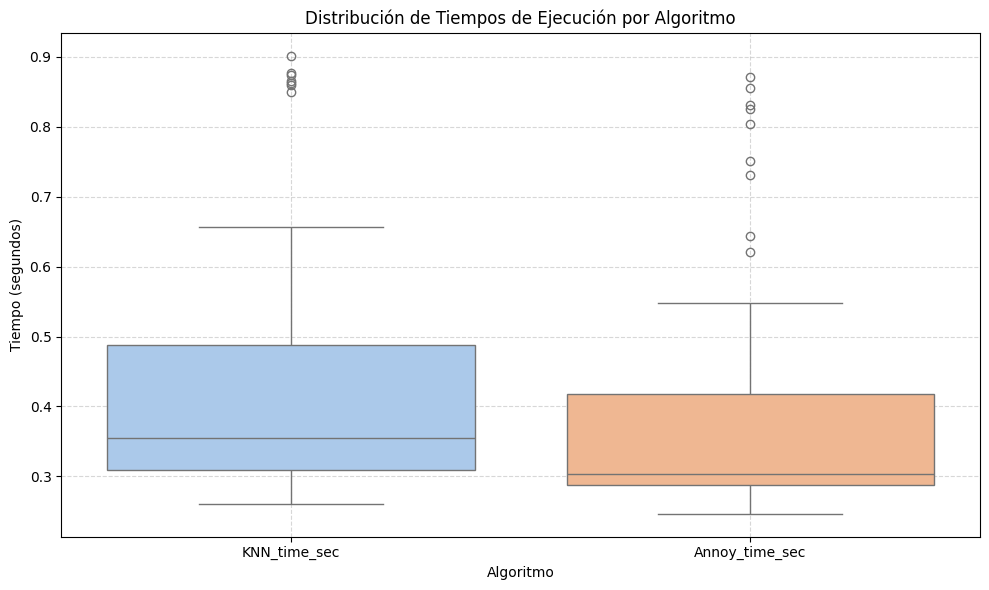

C:\Users\Miguel\AppData\Local\Temp\ipykernel_5316\2037027799.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumen, x="Algoritmo", y="Tiempo (segundos)", palette="Set2")


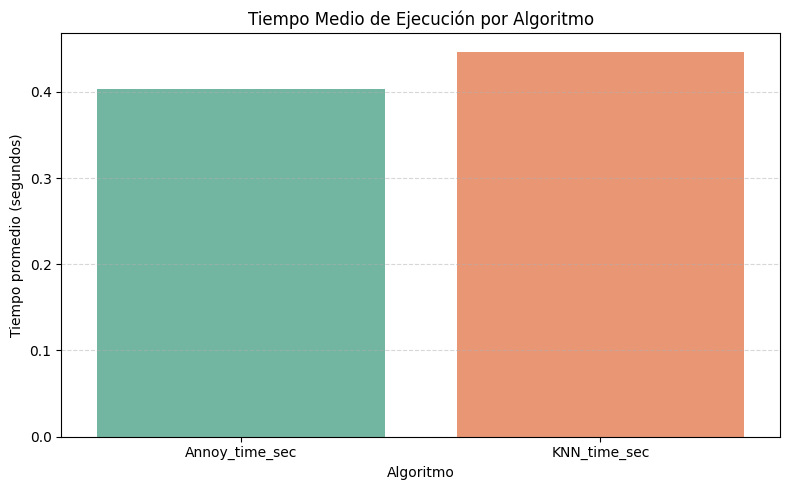

In [16]:
plot_benchmark_comparison(resultados)

## Chatbot de Recomendación en Telegram

### Objetivo

El objetivo de esta sección es desplegar nuestro sistema de recomendación de productos basado en clientes similares como un **chatbot funcional en Telegram**, permitiendo a cualquier usuario interactuar con el sistema de forma conversacional.

### ¿Qué hará el bot?

- Recibirá comandos del tipo `/recomendar <customer_id>`.
- Utilizará el algoritmo Annoy para encontrar los clientes más similares.
- Extraerá productos comprados por esos vecinos y generará una lista recomendada.
- Responderá con un mensaje en Telegram con las recomendaciones personalizadas.

### Ventajas del enfoque

- Permite probar el sistema sin necesidad de interfaz web.
- Es accesible desde cualquier dispositivo móvil o escritorio.
- Sirve como base para futuras integraciones con asistentes virtuales o interfaces más complejas.

### Tecnologías utilizadas

- [`python-telegram-bot`](https://github.com/python-telegram-bot/python-telegram-bot): librería oficial para crear bots de Telegram.
- Python 3, Pandas y PostgreSQL (como fuente de datos).
- Annoy (para búsqueda eficiente de vecinos).

En las siguientes secciones se explica cómo configurar el bot, conectar con el sistema de recomendación y responder con recomendaciones útiles al usuario.


## Crear un Bot en Telegram y obtener el Token de acceso

Antes de poder programar un bot en Telegram, es necesario registrarlo a través de `@BotFather`, el bot oficial de Telegram para crear y gestionar otros bots.

### Pasos para obtener el Token:

1. **Abre Telegram** y busca el usuario: `@BotFather`.
2. Inicia una conversación y envía el comando:
   /newbot

4. Sigue las instrucciones:
- Escribe el **nombre** que tendrá tu bot (puede ser cualquier nombre visible).
- Luego escribe el **nombre de usuario** del bot (debe terminar en `bot`, por ejemplo: `recomendador_bot`).

4. Una vez creado, BotFather te enviará un mensaje con el **Token de acceso**:

In [18]:
from telegram import Update, InputMediaPhoto
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes
from dotenv import load_dotenv
import os
import pandas as pd
import random

# Cargar token
load_dotenv()
TOKEN = os.getenv("TELEGRAM_BOT_TOKEN_CLIENTS")
NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

# Función para obtener datos del cliente
def get_customer_info(customer_id):
    query = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers WHERE customer_id = {customer_id}
    """
    return pd.read_sql_query(query, engine)

# Fallback: productos aleatorios de otros clientes
def obtener_productos_aleatorios(top_n=5):
    clientes_random = random.sample(customer_ids.tolist(), k=3)
    productos = pd.DataFrame()
    for cid in clientes_random:
        comprados = get_purchased_products(cid, engine)
        productos = pd.concat([productos, comprados], ignore_index=True)
    return productos.drop_duplicates("product_id").sample(min(top_n, len(productos)))

# Función con lógica principal (Annoy o fallback)
def obtener_recomendaciones_con_vecinos(customer_id, top_n=5):
    try:
        customer_index = df.index[df["customer_id"] == customer_id][0]
    except IndexError:
        return None, None, None, obtener_productos_aleatorios(top_n)

    vecinos = get_similar_customers_annoy(customer_id, n=5)
    if not vecinos:
        return None, None, None, obtener_productos_aleatorios(top_n)

    vecino_seleccionado = random.choice(vecinos)
    vecino_id, vecino_score = vecino_seleccionado

    productos_comprados = get_purchased_products(customer_id, engine)["product_id"].tolist()
    recomendaciones = pd.DataFrame()
    vecinos_usados = {vecino_id: vecino_score}

    productos = get_purchased_products(vecino_id, engine)
    nuevos = productos[~productos["product_id"].isin(productos_comprados)]
    recomendaciones = pd.concat([recomendaciones, nuevos], ignore_index=True)

    if len(recomendaciones.drop_duplicates("product_id")) < top_n:
        for vid, score in vecinos:
            if vid in vecinos_usados:
                continue
            adicionales = get_purchased_products(vid, engine)
            adicionales = adicionales[~adicionales["product_id"].isin(productos_comprados)]
            if not adicionales.empty:
                recomendaciones = pd.concat([recomendaciones, adicionales], ignore_index=True)
                vecinos_usados[vid] = score
            if len(recomendaciones.drop_duplicates("product_id")) >= top_n:
                break

    return vecino_seleccionado, vecinos_usados, vecinos, recomendaciones.drop_duplicates("product_id").head(top_n)

# Handler del comando /recomendar
async def recomendar(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        customer_id = int(context.args[0])
        cliente = get_customer_info(customer_id)

        if cliente.empty:
            await update.message.reply_text("❌ Cliente no encontrado.")
            return

        first_name = cliente["first_name"].iloc[0]
        last_name = cliente["last_name"].iloc[0]
        email = cliente["email"].iloc[0]

        await update.message.reply_text(
            f"📄 Cliente: {first_name} {last_name}\n📧 Email: {email}"
        )

        # Mostrar historial de compras
        compras = get_purchased_products(customer_id, engine)
        if not compras.empty:
            compras_sample = compras.drop_duplicates("product_id").sample(min(5, len(compras)))
            media_compras = []
            for _, row in compras_sample.iterrows():
                nombre = row["productdisplayname"]
                imagen = row["image_url"] if pd.notnull(row["image_url"]) else NO_IMAGE_URL
                media_compras.append(InputMediaPhoto(media=imagen, caption=f"🛒 {nombre}"))

            await update.message.reply_text("📦 Aquí tienes algunos de los productos que has comprado recientemente:")
            await context.bot.send_media_group(chat_id=update.effective_chat.id, media=media_compras)

        # Obtener recomendaciones (Annoy o fallback)
        vecino, vecinos_usados, vecinos_top, productos = obtener_recomendaciones_con_vecinos(customer_id)

        if productos.empty:
            await update.message.reply_text("No se encontraron productos para recomendar.")
            return

        if vecino is None:
            await update.message.reply_text(
                "⚠️ Este cliente no se encuentra en el sistema de similitud.\nTe mostramos recomendaciones generales basadas en otros usuarios."
            )
        else:
            vecino_id, vecino_score = vecino
            await update.message.reply_text(
                f"👥 Cliente similar seleccionado:\nID: {vecino_id}\nScore: {vecino_score:.4f}"
            )
            if len(vecinos_usados) > 1:
                texto_vecinos = "\n".join(
                    [f"• ID {vid} → score {score:.4f}" for vid, score in vecinos_usados.items()]
                )
                await update.message.reply_text(
                    f"ℹ️ Se usaron estos clientes similares para completar las recomendaciones:\n{texto_vecinos}"
                )

        # Enviar recomendaciones como álbum
        media_recos = []
        for _, row in productos.iterrows():
            nombre = row["productdisplayname"]
            imagen = row["image_url"] if pd.notnull(row["image_url"]) else NO_IMAGE_URL
            media_recos.append(InputMediaPhoto(media=imagen, caption=f"🛍️ {nombre}"))

        await update.message.reply_text("🎯 Basándonos en otros clientes similares, te recomendamos:")
        await context.bot.send_media_group(chat_id=update.effective_chat.id, media=media_recos)

    except:
        await update.message.reply_text("⚠️ Usa un ID válido. Ejemplo: /recomendar 12345")

# /start
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text("👋 Usa /recomendar <ID> para obtener productos personalizados o sugerencias generales.")

# Inicializar bot
app = ApplicationBuilder().token(TOKEN).build()
app.add_handler(CommandHandler("start", start))
app.add_handler(CommandHandler("recomendar", recomendar))

async def start_bot():
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    print("🤖 Bot iniciado con fallback a recomendaciones generales...")

await start_bot()


🤖 Bot iniciado con fallback a recomendaciones generales...


Exception happened while polling for updates.
Traceback (most recent call last):
  File "C:\Python312\Lib\site-packages\telegram\ext\_utils\networkloop.py", line 115, in network_retry_loop
    if not await do_action():
           ^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\telegram\ext\_utils\networkloop.py", line 108, in do_action
    return action_cb_task.result()
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\telegram\ext\_updater.py", line 335, in polling_action_cb
    updates = await self.bot.get_updates(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\telegram\ext\_extbot.py", line 669, in get_updates
    updates = await super().get_updates(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\telegram\_bot.py", line 4601, in get_updates
    await self._post(
  File "C:\Python312\Lib\site-packages\telegram\_bot.py", line 697, in _post
    return await self._do_post(
           ^^^^

## Visualización completa en el bot de Telegram: historial de compras y recomendaciones

En esta sección hemos extendido la funcionalidad del bot para que proporcione una experiencia más completa y personalizada. El comando `/recomendar <customer_id>` ahora realiza las siguientes acciones:

### ¿Qué muestra el bot?

1. **Datos del cliente**
   - Nombre, apellidos y correo electrónico.
   - Confirmación de que se ha encontrado correctamente en la base de datos.

2. **Historial de compras recientes**
   - Hasta 5 productos comprados previamente por el cliente.
   - Mostrados como un álbum de imágenes (nombre + imagen del producto).
   - Esto permite que el usuario reconozca su actividad reciente.

3. **Recomendaciones personalizadas**
   - Se busca un cliente similar mediante Annoy.
   - Si se necesita, se completan productos usando otros vecinos del top 5.
   - Se muestra el `customer_id` del vecino seleccionado y su `similarity_score`.
   - Se informa si se han usado varios vecinos adicionales.
   - Las recomendaciones se presentan como otro álbum de imágenes.

4. **Fallback automático**
   - Si el cliente no está en el índice Annoy, se seleccionan productos de otros clientes aleatorios.
   - Se notifica al usuario que se han generado recomendaciones generales.

### Ventajas de esta presentación

- Experiencia visual atractiva directamente en Telegram.
- Claridad total sobre la lógica de recomendación.
- Mayor confianza del usuario al ver productos comprados y sugeridos.
- Lógica robusta que siempre responde, incluso sin historial o segmentación.

Este diseño convierte al bot en una interfaz accesible, útil y fácil de usar para navegar recomendaciones personalizadas.
